<a href="https://colab.research.google.com/github/AURORARISE/MSSP-6070/blob/main/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load Data and Data Wash

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats
DATA_PATH = Path("/content/drive/MyDrive/MSSP6070/a. Assignments/Assignment1/data_academic_performance.xlsx")
xls = pd.ExcelFile(DATA_PATH)
sheet_name = "SABER11_SABERPRO" if "SABER11_SABERPRO" in xls.sheet_names else max(
    xls.sheet_names, key=lambda sn: pd.read_excel(DATA_PATH, sheet_name=sn, nrows=5).shape[1]
)

df = pd.read_excel(DATA_PATH, sheet_name=sheet_name)
drop_cols = [c for c in df.columns if str(c).startswith("Unnamed")]
df = df.drop(columns=drop_cols, errors='ignore')
outcomes = ["MAT_S11","CR_S11","CC_S11","BIO_S11","ENG_S11",
            "QR_PRO","CR_PRO","CC_PRO","ENG_PRO","WC_PRO",
            "G_SC","PERCENTILE"]
outcomes = [c for c in outcomes if c in df.columns]

Appendix A：Parental Education vs Outcomes

In [21]:
edu_order = [
    "None",
    "Incomplete primary",
    "Complete primary",
    "Incomplete secondary",
    "Complete secondary",
    "Incomplete technical/technological",
    "Complete technique or technology",
    "Incomplete professional education",
    "Complete professional education",
    "Postgraduate education",
]

def normalize_edu(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().lower()
    mapping = {
        "ninguno": "None",
        "not sure": np.nan,
        "incomplete primary": "Incomplete primary",
        "complete primary": "Complete primary",
        "incomplete secundary": "Incomplete secondary",
        "complete secundary": "Complete secondary",
        "incomplete technical or technological": "Incomplete technical/technological",
        "complete technique or technology": "Complete technique or technology",
        "incomplete professional education": "Incomplete professional education",
        "complete professional education": "Complete professional education",
        "postgraduate education": "Postgraduate education",
    }
    s = s.replace("  ", " ").strip()
    return mapping.get(s, x)

df["EDU_FATHER_N"] = df["EDU_FATHER"].apply(normalize_edu)
df["EDU_MOTHER_N"] = df["EDU_MOTHER"].apply(normalize_edu)

edu_dtype = pd.CategoricalDtype(categories=edu_order, ordered=True)
df["EDU_FATHER_ORD"] = df["EDU_FATHER_N"].astype(edu_dtype)
df["EDU_MOTHER_ORD"] = df["EDU_MOTHER_N"].astype(edu_dtype)

df["EDU_FATHER_CODE"] = df["EDU_FATHER_ORD"].cat.codes.replace({-1: np.nan})
df["EDU_MOTHER_CODE"] = df["EDU_MOTHER_ORD"].cat.codes.replace({-1: np.nan})

corr_f = df[["EDU_FATHER_CODE"] + outcomes].corr().loc["EDU_FATHER_CODE", outcomes]
corr_m = df[["EDU_MOTHER_CODE"] + outcomes].corr().loc["EDU_MOTHER_CODE", outcomes]
parent_corrs = pd.DataFrame({"FatherEdu_vs": corr_f, "MotherEdu_vs": corr_m})

print("Appendix A — Correlation Table: Parental Education vs Outcomes")
display(parent_corrs.round(3))

Appendix A — Correlation Table: Parental Education vs Outcomes


,FatherEdu_vs,MotherEdu_vs
MAT_S11,0.260,0.255
CR_S11,0.211,0.214
CC_S11,0.194,0.192
BIO_S11,0.236,0.228
ENG_S11,0.376,0.375
QR_PRO,0.168,0.165
CR_PRO,0.170,0.175
CC_PRO,0.166,0.162
ENG_PRO,0.330,0.331
WC_PRO,0.102,0.113


Appendix B：Mean Scores by Stratum

In [22]:
def stratum_to_num(s):
    if pd.isna(s): return np.nan
    s = str(s).strip().lower()
    if s.startswith("stratum"):
        try:
            return int(s.split()[-1])
        except:
            return np.nan
    try:
        return int(s)
    except:
        return np.nan

df["STRATUM_NUM"] = df["STRATUM"].apply(stratum_to_num)

stratum_means = df.groupby("STRATUM")[["G_SC","PERCENTILE","QR_PRO","CR_PRO","ENG_PRO","WC_PRO"]].mean()

print("Appendix B — Mean Scores by Socioeconomic Stratum")
display(stratum_means.round(2))

anova_groups = [sub["G_SC"].dropna() for _, sub in df.groupby("STRATUM") if sub["G_SC"].notna().sum() > 5]
if len(anova_groups) >= 2:
    F, p = stats.f_oneway(*anova_groups)
    print(f"(ANOVA) G_SC by Stratum: F={F:.3f}, p={p:.6f}")

Appendix B — Mean Scores by Socioeconomic Stratum


,G_SC,PERCENTILE,QR_PRO,CR_PRO,ENG_PRO,WC_PRO
STRATUM,,,,,,
0,154.00,58.86,69.79,47.36,55.07,60.50
Stratum 1,152.35,56.97,70.52,53.57,50.91,49.30
Stratum 2,158.20,63.67,74.62,58.82,60.95,51.15
Stratum 3,163.82,70.15,78.34,63.86,70.62,53.04
Stratum 4,172.00,78.43,83.22,69.27,80.10,59.59
Stratum 5,177.39,83.20,86.70,71.75,87.00,63.66
Stratum 6,181.51,85.83,88.36,73.76,92.45,65.59


(ANOVA) G_SC by Stratum: F=238.769, p=0.000000


Appendix C：Gender Differences Table

In [23]:
def cohens_d(x, y):
    x, y = x.dropna(), y.dropna()
    if len(x) < 2 or len(y) < 2: return np.nan
    pooled = ((len(x)-1)*x.var(ddof=1) + (len(y)-1)*y.var(ddof=1)) / (len(x)+len(y)-2)
    if pooled <= 0: return np.nan
    return (x.mean() - y.mean()) / np.sqrt(pooled)

gender_metrics = {}
for col in ["G_SC","QR_PRO","CR_PRO","CC_PRO","ENG_PRO","WC_PRO","PERCENTILE"]:
    if col not in df.columns:
        continue
    group_means = df.groupby("GENDER")[col].mean()
    d = cohens_d(df[df["GENDER"]=="M"][col], df[df["GENDER"]=="F"][col])
    gender_metrics[col] = {
        "Male_mean": group_means.get("M", np.nan),
        "Female_mean": group_means.get("F", np.nan),
        "Difference_(M-F)": group_means.get("M", np.nan) - group_means.get("F", np.nan),
        "Cohens_d": d
    }

gender_df = pd.DataFrame(gender_metrics).T

print("Appendix C — Gender Differences (Means & Cohen's d)")
display(gender_df.round(2))

Appendix C — Gender Differences (Means & Cohen's d)


,Male_mean,Female_mean,Difference_(M-F),Cohens_d
G_SC,163.69,161.28,2.41,0.10
QR_PRO,81.20,71.89,9.31,0.42
CR_PRO,62.79,61.34,1.45,0.05
CC_PRO,59.61,58.57,1.03,0.04
ENG_PRO,68.16,66.53,1.63,0.06
WC_PRO,51.71,56.62,-4.91,-0.16
PERCENTILE,69.35,67.13,2.21,0.09


Appendix D：Visualizations

<Figure size 640x480 with 0 Axes>

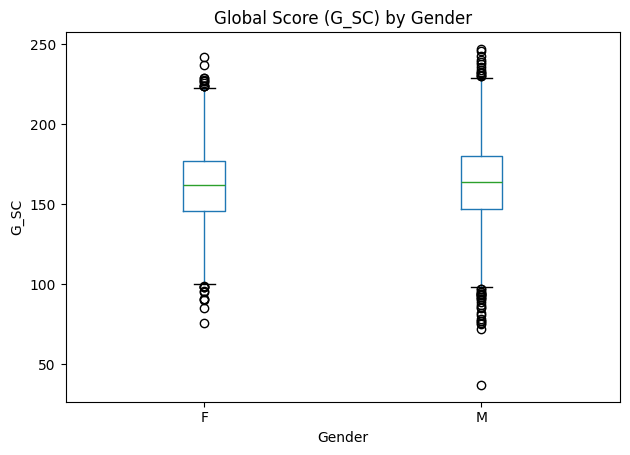

<Figure size 640x480 with 0 Axes>

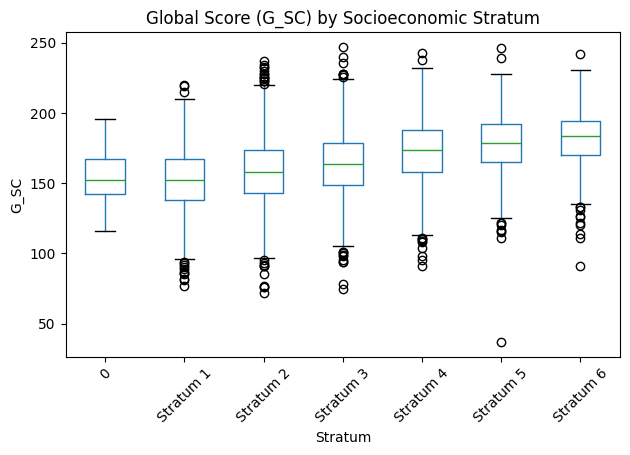

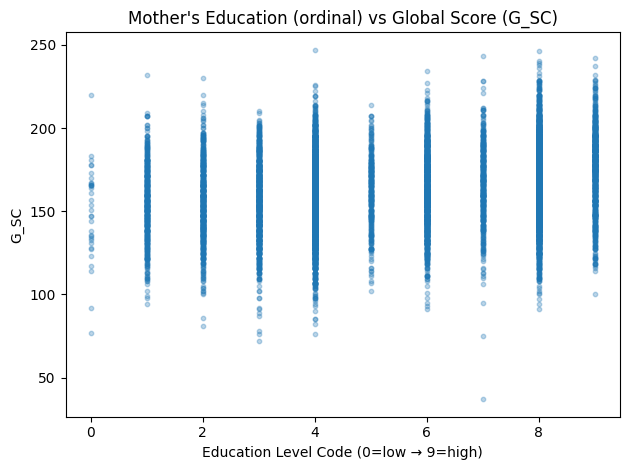

In [24]:
if "G_SC" in df.columns and "GENDER" in df.columns:
    plt.figure()
    df.boxplot(column="G_SC", by="GENDER", grid=False)
    plt.title("Global Score (G_SC) by Gender")
    plt.suptitle("")
    plt.xlabel("Gender")
    plt.ylabel("G_SC")
    plt.tight_layout()
    plt.show()

if "G_SC" in df.columns and "STRATUM" in df.columns:
    plt.figure()
    df.boxplot(column="G_SC", by="STRATUM", grid=False, rot=45)
    plt.title("Global Score (G_SC) by Socioeconomic Stratum")
    plt.suptitle("")
    plt.xlabel("Stratum")
    plt.ylabel("G_SC")
    plt.tight_layout()
    plt.show()

if "EDU_MOTHER_ORD" in df.columns and "G_SC" in df.columns:
    x = df["EDU_MOTHER_ORD"].cat.codes.replace({-1: np.nan})
    y = df["G_SC"]
    plt.figure()
    plt.scatter(x, y, s=10, alpha=0.3)
    plt.title("Mother's Education (ordinal) vs Global Score (G_SC)")
    plt.xlabel("Education Level Code (0=low → 9=high)")
    plt.ylabel("G_SC")
    plt.tight_layout()
    plt.show()